# Avian Flu Data

In [1]:
# Import libraries
import numpy as np
import math
import branchpro
import scipy.stats
from branchpro.apps import ReproductionNumberPlot
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pandas as pd
from cmdstanpy import CmdStanModel,  cmdstan_path
import arviz as az
import nest_asyncio
import seaborn as sns
nest_asyncio.apply()

num_timepoints = 21 # number of days for incidence data
num_categories = 2

trace_names = ['0-19 years old', '20+ years old']

## Parametrisation of the renewal model

In [2]:
# Build the serial interval w_s
ws_mean = 1.9
coeff_var = 0.47
ws_std = coeff_var * ws_mean

theta = ws_std**2 / ws_mean
k = ws_mean / theta
w_dist = scipy.stats.gamma(k, scale=theta)
disc_w = w_dist.pdf(np.arange(30))

serial_interval = disc_w

# Select a range of different contact matrices

path = os.path.join('../../data_library/polymod/final_contact_matrices/', 'BASE_Japan.csv')
contact_matrix = pd.read_csv(path, header=None).to_numpy()

# Choose unique transmissibilityt vector for ease so
# effective contact matrix = contact matrix
transmissibility = [1, 1]

# Number of cases
desagg_cases = np.array(
    [[5, 0], [5, 0], [7, 0], [6, 1], 
     [7, 3], [15, 1], [41, 4], [54, 5],
     [54, 10], [37, 11], [29, 5], [13, 7], 
     [8, 6], [4, 1], [5, 0], [1, 0],
     [2, 1], [2, 4], [2, 0], [2, 0], [3, 0]]
)

agg_cases = np.sum(desagg_cases, axis=1)

## Plot the Incidence Data

In [18]:
# Plot (bar chart cases each day)
fig = go.Figure()

# Plot of incidences
fig.add_trace(
    go.Bar(
        x=np.arange(num_timepoints),
        y=desagg_cases[:, 0],
        name='Incidences 0-19'
    )
)

fig.add_trace(
    go.Bar(
        x=np.arange(num_timepoints),
        y=desagg_cases[:, 1],
        name='Incidences 20+'
    )
)

# Add axis labels
fig.update_layout(
    xaxis_title='Time (days)',
    yaxis_title='New infections',
    width=900, 
    height=600,
    plot_bgcolor='white',
    font=dict(
            size=16),
    xaxis=dict(
        linecolor='black'),
    yaxis=dict(
        linecolor='black'),
    legend=dict(
            yanchor="bottom",
            y=0.8,
            xanchor="right",
            x=0.95,
            bordercolor="Black",
            borderwidth=1
        )
)

fig.write_image('images/Incidence Avian Flu .pdf')

fig.show()

## R_t inference using STAN

In [4]:
# Same inference, but using the PoissonBranchProPosterior
tau = 6
R_t_start = tau+1
a = 1
b = 1/5
sigma = 1.5

In [5]:
# Transform our incidence data into pandas dataframes
multicat_inc_data_matrix = {'Time': np.arange(num_timepoints)}

for _ in range(num_categories):
    multicat_inc_data_matrix['Incidence Number Cat {}'.format(_+1)] = \
        desagg_cases[:, _]

multicat_inc_data = pd.DataFrame(multicat_inc_data_matrix)

inc_data = pd.DataFrame(
    {
        'Time': np.arange(num_timepoints),
        'Incidence Number': agg_cases
    }
)

eff_contact_matrix = np.matmul(contact_matrix, np.diag(transmissibility))
spec_radius = np.max(np.absolute(np.linalg.eigvals(eff_contact_matrix)))

# Correction for reproduction number per category
correc_i = np.multiply(np.sum(contact_matrix, axis=0), transmissibility) / spec_radius

L1 = len(np.arange(R_t_start, num_timepoints))

## Multiple group model

In [6]:
approx_multicat_model = """
functions {
    real normalizing_const (array [] real aSI) {
        return sum(aSI);
    }
    real effective_no_infectives (
        int N, int S, int n, int i, int t, array [,] real aI, array [] real aSI,
        array [,] real C, array [] real transm) {
            real mean;

            mean = 0;
            for(j in 1:n){
                if(t > S) {
                    mean += C[i,j] * transm[j] * (
                        dot_product(aI[(t-S):(t-1), j], aSI) /
                        normalizing_const(aSI));
                }
                else {
                    mean += C[i,j] * transm[j] * (
                        dot_product(aI[:(t-1), j], aSI[(S-t+2):]) /
                        normalizing_const(aSI));
                }
            }
            return mean;
    }
}
data {
    int N; // number of days
    int S; // length serial interval
    int n; // number of categories
    array [n, n] real C; // contact matrix
    real specC; // spectral radius of effective contact matrix
    array [n] real transm; // transmissibility vector
    array [N, n] int I; // local incidences for N days
    int tau; // sliding window
    array [S] real revSI; // reversed serial interval
    real a; // prior shape parameter
    real b; // prior rate parameter
    real<lower=0> sigma; // prior std parameter
}
parameters {
    array [N-tau-1] real<lower=0> R; // vector of R numbers
}
model {
    for(t in (tau+1):(N-1)) {
        for (i in 1:n){
            for(k in (t-tau+1):(t+1)) {
                if (effective_no_infectives(N, S, n, i, k, I, revSI, C, transm) != 0) {
                    I[k, i] ~ poisson (
                        R[t-tau] * effective_no_infectives(
                            N, S, n, i, k, I, revSI, C, transm) / specC); // likelihood
                        }
            }
        }
    }
    for(t in 1:(N-tau-1)) {
        R[t] ~ gamma (a, b); // prior of R
    }
}
"""

approx_multicat_data = {
    'N': num_timepoints,
    'S': len(serial_interval),
    'n': num_categories,
    'C': contact_matrix,
    'specC': spec_radius,
    'transm': transmissibility,
    'I': desagg_cases.astype(np.integer).tolist(),
    'tau': tau,
    'revSI': serial_interval.tolist()[::-1],
    'a': a,
    'b': b,
    'sigma': sigma}

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_5200/62481197.py:69: DeprecationWarning:

Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.



In [7]:
posterior = stan.build(
    approx_multicat_model, data=approx_multicat_data, random_seed=10)

fit = posterior.sample(
    num_chains=3, num_samples=1000)

samples = az.from_cmdstanpy(
    fit,
    observed_data='I',
    coords={'observation': list(range(num_timepoints)),
            'covariate': [
                '{}'.format(_)
                for _ in range(num_timepoints - R_t_start)]
            },
    dims={
        'I': ['observation'],
        'R': ['covariate']
        })

az.summary(samples)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/6000)
Sampling:   0% (2/6000)
Sampling:   0% (3/6000)
Sampling:   2% (102/6000)
Sampling:   3% (201/6000)
Sampling:   5% (300/6000)
Sampling:   7% (400/6000)
Sampling:   8% (500/6000)
Sampling:  10% (600/6000)
Sampling:  12% (700/6000)
Sampling:  13% (800/6000)
Sampling:  15% (900/6000)
Sampling:  17% (1000/6000)
Sampling:  18% (1100/6000)
Sampling:  20% (1200/6000)
Sampling:  22% (1300/6000)
Sampling:  23% (1400/6000)
Sampling:  25% (1500/6000)
Sampling:  27% (1600/6000)
Sampling:  28% (1700/6000)
Sampling:  30% (1800/6000)
Sampling:  32% (1900/6000)
Sampling:  33% (2000/6000)
Sampling:  35% (2100/6000)
Sampling:  37% (2200/6000)
Sampling:  38% (2300/6000)
Sampling:  40% (2400/6000)
Sampling:  42% (2500/6000)
Sampling:  43% (2600/6000)
Sampling:  45% (2700/6000)
Sampling:  47% (2801/6000)
Samp

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
R[0],3.341,0.279,2.837,3.863,0.003,0.002,6596.0,1844.0,1.0
R[1],2.868,0.192,2.513,3.223,0.002,0.002,6677.0,2139.0,1.0
R[2],2.062,0.131,1.821,2.306,0.002,0.001,6580.0,2181.0,1.0
R[3],1.527,0.092,1.362,1.706,0.001,0.001,7521.0,2022.0,1.0
R[4],1.206,0.071,1.079,1.339,0.001,0.001,6571.0,2090.0,1.0
R[5],1.011,0.060,0.899,1.120,0.001,0.001,7049.0,2377.0,1.0
R[6],0.792,0.051,0.702,0.888,0.001,0.000,7235.0,2302.0,1.0
R[7],0.597,0.045,0.514,0.683,0.000,0.000,8211.0,1672.0,1.0
R[8],0.421,0.037,0.352,0.488,0.000,0.000,7377.0,2212.0,1.0
R[9],0.318,0.035,0.256,0.383,0.000,0.000,7251.0,2247.0,1.0


array([[<AxesSubplot:title={'center':'R\n0'}>,
        <AxesSubplot:title={'center':'R\n0'}>],
       [<AxesSubplot:title={'center':'R\n1'}>,
        <AxesSubplot:title={'center':'R\n1'}>],
       [<AxesSubplot:title={'center':'R\n2'}>,
        <AxesSubplot:title={'center':'R\n2'}>],
       [<AxesSubplot:title={'center':'R\n3'}>,
        <AxesSubplot:title={'center':'R\n3'}>],
       [<AxesSubplot:title={'center':'R\n4'}>,
        <AxesSubplot:title={'center':'R\n4'}>],
       [<AxesSubplot:title={'center':'R\n5'}>,
        <AxesSubplot:title={'center':'R\n5'}>],
       [<AxesSubplot:title={'center':'R\n6'}>,
        <AxesSubplot:title={'center':'R\n6'}>],
       [<AxesSubplot:title={'center':'R\n7'}>,
        <AxesSubplot:title={'center':'R\n7'}>],
       [<AxesSubplot:title={'center':'R\n8'}>,
        <AxesSubplot:title={'center':'R\n8'}>],
       [<AxesSubplot:title={'center':'R\n9'}>,
        <AxesSubplot:title={'center':'R\n9'}>],
       [<AxesSubplot:title={'center':'R\n10'}>,
  

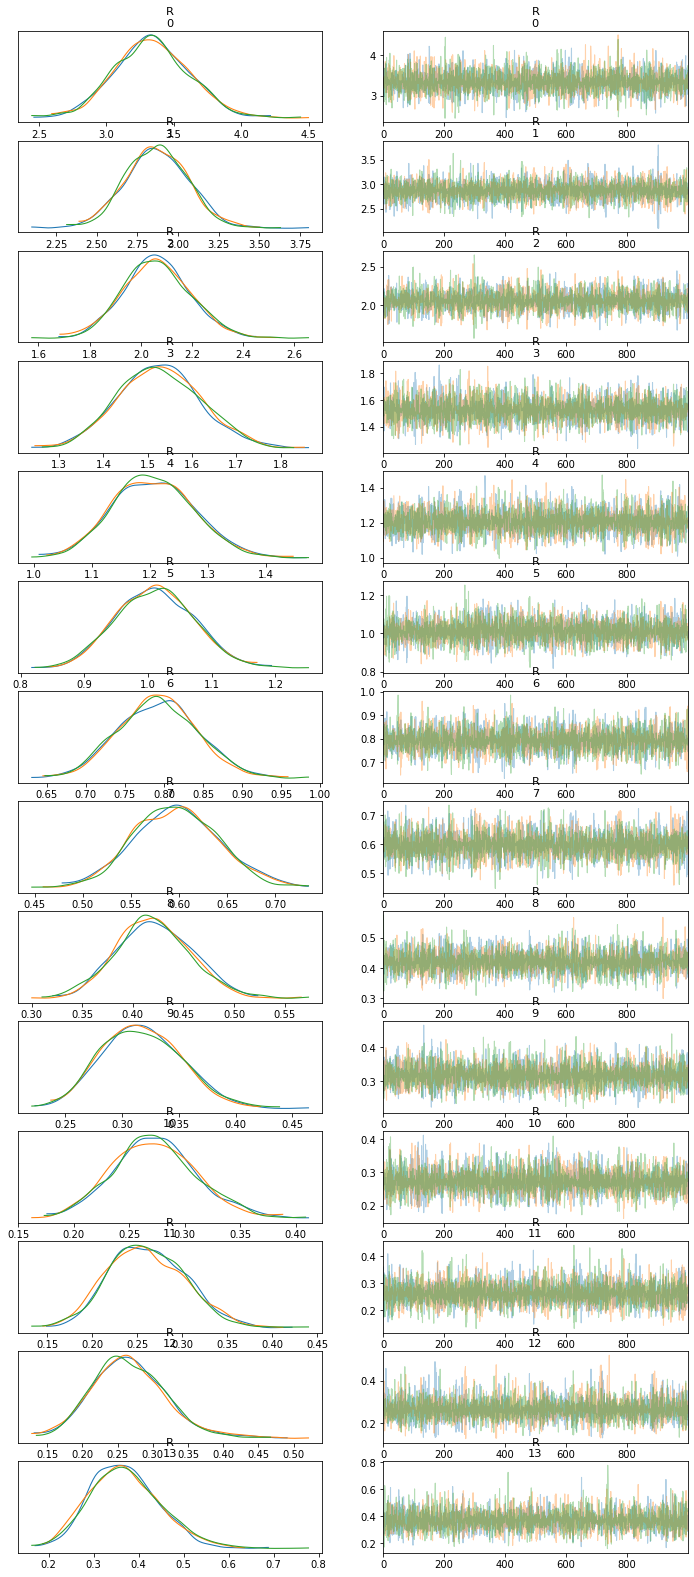

In [8]:
az.rcParams['plot.max_subplots'] = 2*(num_timepoints - R_t_start)

az.plot_trace(
    samples,
    var_names=('R'),
    filter_vars='like',
    compact=False)

In [9]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
chain_samples = fit._draws[7:, 500:, :]

# Evaluate the model for all parameter sets in the samples
n_param, n_sample, n_chains = chain_samples.shape

extended_samples = np.concatenate((
    chain_samples[:, :, 0],
    chain_samples[:, :, 1],
    chain_samples[:, :, 2]), axis=1)

thinning = max(1, int(n_sample * n_chains / 500))
approx_multicat_intervals = []

for j in range(num_categories):
    approx_multicat_intervals.append(pd.DataFrame({
        'Time Points': np.arange(R_t_start, num_timepoints),
        'Mean': np.mean(correc_i[j] * extended_samples[:, ::thinning], axis=1),
        'Lower bound CI': np.quantile(correc_i[j] * extended_samples[:, ::thinning], 0.025, axis=1),
        'Upper bound CI': np.quantile(correc_i[j] * extended_samples[:, ::thinning], 0.975, axis=1),
        'Central Probability': L1 * [0.95]
    }))

overall_approx_multicat_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(extended_samples[:, ::thinning], axis=1),
    'Lower bound CI': np.quantile(extended_samples[:, ::thinning], 0.025, axis=1),
    'Upper bound CI': np.quantile(extended_samples[:, ::thinning], 0.975, axis=1),
    'Central Probability': L1 * [0.95]
})

## One group model

In [10]:
poisson_model = """
functions {
    real normalizing_const (array [] real aSI) {
        return sum(aSI);
    }
    real effective_no_infectives (
        int N, int S, int t, array [] real aI, array [] real aSI) {
            real mean;
            if(t > S) {
                mean = (
                    dot_product(aI[(t-S):(t-1)], aSI) /
                    normalizing_const(aSI));
            }
            else {
                mean = (
                    dot_product(aI[:(t-1)], aSI[(S-t+2):]) /
                    normalizing_const(aSI));
            }
            return mean;
    }
}
data {
    int N; // number of days
    int S; // length serial interval
    array [N] int I; // local incidences for N days
    int tau; // sliding window
    array [S] real revSI; // reversed serial interval
    real a; // prior shape parameter
    real b; // prior rate parameter
    real<lower=0> sigma; // prior std parameter
}
parameters {
    array [N-tau-1] real<lower=0> R; // vector of R numbers
}
model {
    for(t in (tau+1):(N-1)) {
        for(k in (t-tau+1):(t+1)) {
            if (effective_no_infectives(N, S, k, I, revSI) != 0) {
                I[k] ~ poisson (
                    R[t-tau] * effective_no_infectives(
                        N, S, k, I, revSI)); // likelihood
                    }
        }
    }
    for(t in 1:(N-tau-1)) {
        R[t] ~ gamma (a, b); // prior of R
    }
}
"""

poisson_data = {
    'N': num_timepoints,
    'S': len(serial_interval),
    'I': agg_cases.astype(np.integer).tolist(),
    'tau': tau,
    'revSI': serial_interval.tolist()[::-1],
    'a': a,
    'b': b,
    'sigma': sigma}

/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/ipykernel_5200/1887272557.py:54: DeprecationWarning:

Converting `np.integer` or `np.signedinteger` to a dtype is deprecated. The current result is `np.dtype(np.int_)` which is not strictly correct. Note that the result depends on the system. To ensure stable results use may want to use `np.int64` or `np.int32`.



In [11]:
posterior = stan.build(
    poisson_model, data=poisson_data, random_seed=10)

fit = posterior.sample(
    num_chains=3, num_samples=1000)

samples = az.from_cmdstanpy(
    fit,
    observed_data='I',
    coords={'observation': list(range(num_timepoints)),
            'covariate': [
                '{}'.format(_)
                for _ in range(num_timepoints - R_t_start)]
            },
    dims={
        'I': ['observation'],
        'R': ['covariate']
        })

az.summary(samples)

Building...



Building: found in cache, done.Messages from stanc:
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.
Sampling:   0%
Sampling:   0% (1/6000)
Sampling:   0% (2/6000)
Sampling:   0% (3/6000)
Sampling:   5% (302/6000)
Sampling:  10% (601/6000)
Sampling:  15% (900/6000)
Sampling:  20% (1200/6000)
Sampling:  27% (1600/6000)
Sampling:  33% (2000/6000)
Sampling:  57% (3400/6000)
Sampling:  78% (4700/6000)
Sampling: 100% (6000/6000)
Sampling: 100% (6000/6000), done.
Messages received during sampling:
  Gradient evaluation took 0.004386 seconds
  1000 transitions using 10 leapfrog steps per transition would take 43.86 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: gamma_lpdf: Random variable is inf, but must be positive finite! (in '/var/folders/ph/jyxnc9y52svgq2k5lt2q4r000000gp/T/httpstan_3__gswa5/model_hwu4i

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
R[0],3.836,0.318,3.280,4.453,0.004,0.003,7972.0,2194.0,1.00
R[1],3.283,0.221,2.867,3.694,0.003,0.002,6592.0,2222.0,1.00
R[2],2.364,0.152,2.081,2.648,0.002,0.001,7454.0,2294.0,1.01
R[3],1.752,0.105,1.562,1.949,0.001,0.001,7254.0,2408.0,1.00
R[4],1.378,0.084,1.225,1.531,0.001,0.001,6716.0,2223.0,1.00
R[5],1.151,0.069,1.024,1.277,0.001,0.001,7186.0,1868.0,1.00
R[6],0.903,0.059,0.799,1.017,0.001,0.000,8310.0,1931.0,1.01
R[7],0.680,0.049,0.591,0.773,0.001,0.000,7405.0,2180.0,1.00
R[8],0.477,0.042,0.401,0.557,0.001,0.000,6433.0,2238.0,1.00
R[9],0.358,0.039,0.281,0.429,0.000,0.000,7922.0,2235.0,1.00


array([[<AxesSubplot:title={'center':'R\n0'}>,
        <AxesSubplot:title={'center':'R\n0'}>],
       [<AxesSubplot:title={'center':'R\n1'}>,
        <AxesSubplot:title={'center':'R\n1'}>],
       [<AxesSubplot:title={'center':'R\n2'}>,
        <AxesSubplot:title={'center':'R\n2'}>],
       [<AxesSubplot:title={'center':'R\n3'}>,
        <AxesSubplot:title={'center':'R\n3'}>],
       [<AxesSubplot:title={'center':'R\n4'}>,
        <AxesSubplot:title={'center':'R\n4'}>],
       [<AxesSubplot:title={'center':'R\n5'}>,
        <AxesSubplot:title={'center':'R\n5'}>],
       [<AxesSubplot:title={'center':'R\n6'}>,
        <AxesSubplot:title={'center':'R\n6'}>],
       [<AxesSubplot:title={'center':'R\n7'}>,
        <AxesSubplot:title={'center':'R\n7'}>],
       [<AxesSubplot:title={'center':'R\n8'}>,
        <AxesSubplot:title={'center':'R\n8'}>],
       [<AxesSubplot:title={'center':'R\n9'}>,
        <AxesSubplot:title={'center':'R\n9'}>],
       [<AxesSubplot:title={'center':'R\n10'}>,
  

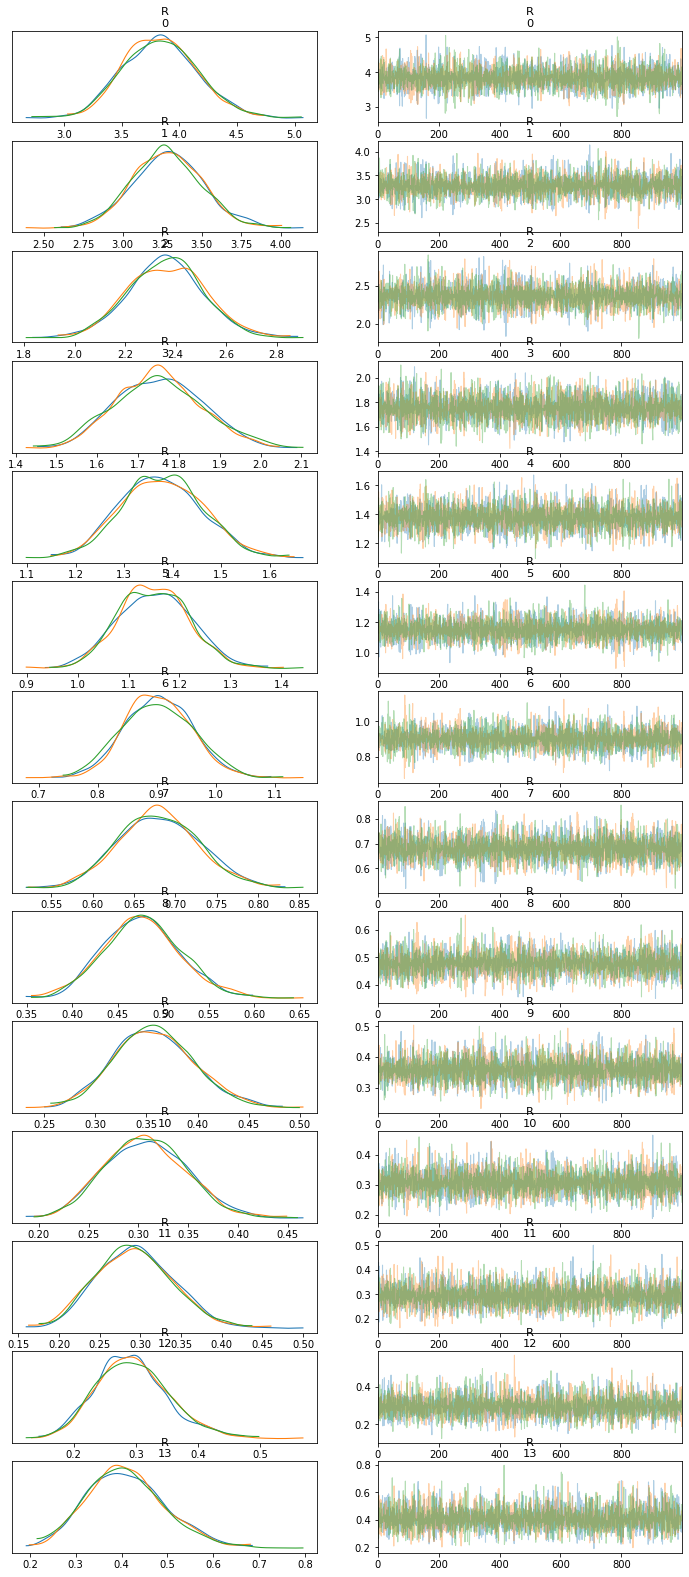

In [12]:
az.rcParams['plot.max_subplots'] = 2*(num_timepoints - R_t_start)

az.plot_trace(
    samples,
    var_names=('R'),
    filter_vars='like',
    compact=False)

In [13]:
# Eliminate burn-in iterations (1/2 of the chain lengths)
chain_samples = fit._draws[7:, 500:, :]

# Evaluate the model for all parameter sets in the samples
n_param, n_sample, n_chains = chain_samples.shape

extended_samples = np.concatenate((
    chain_samples[:, :, 0],
    chain_samples[:, :, 1],
    chain_samples[:, :, 2]), axis=1)

thinning = max(1, int(n_sample * n_chains / 500))

pois_intervals = pd.DataFrame({
    'Time Points': np.arange(R_t_start, num_timepoints),
    'Mean': np.mean(extended_samples[:, ::thinning], axis=1),
    'Lower bound CI': np.quantile(extended_samples[:, ::thinning], 0.025, axis=1),
    'Upper bound CI': np.quantile(extended_samples[:, ::thinning], 0.975, axis=1),
    'Central Probability': L1 * [0.95]
})

In [16]:
colour_names = ['#EC9F0A', '#D41159', '#1A85FF']

fig = ReproductionNumberPlot()

for j in range(num_categories):
    fig.add_interval_rt(approx_multicat_intervals[j], colour=colour_names[0], shape=[None, 'dash'][j], model_type='Multiple Group Model, {}'.format(trace_names[j]))
fig.add_interval_rt(overall_approx_multicat_intervals, colour=colour_names[1], model_type='Multiple Group Model, overall')
fig.add_interval_rt(pois_intervals, colour=colour_names[2], model_type='One Group Model')
    
fig.update_labels(time_label='Time (days)', r_label='Reproduction number R<sub>t</sub>')

fig.figure.data = [fig.figure.data[0], fig.figure.data[2], fig.figure.data[4], fig.figure.data[6]]

fig.figure.add_hline(
    y=1, line_dash='dot',
    annotation_text='R<sub>t</sub>=1', fillcolor='black',
    annotation_position='top right')

fig.figure.update_layout(
    width=900, 
    height=600,
    plot_bgcolor='white',
    font=dict(
            size=16),
    xaxis=dict(
        linecolor='black'),
    yaxis=dict(
        linecolor='black'),
    legend=dict(
            orientation="h",
            yanchor="bottom",
            y=0.8,
            xanchor="right",
            x=1.05,
            bordercolor="Black",
            borderwidth=1
        )
)

fig.figure.write_image('images/Avian Flu.pdf')

fig.show_figure()